# Loading libraries

In [6]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [7]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Loading MNIST dataset and creating training and validation dataset

In [8]:
#Path for MNIST full dataset
path = untar_data(URLs.MNIST)
path

Path('/home/jupyter/.fastai/data/mnist_png')

In [9]:
path.ls()

(#2) [Path('/home/jupyter/.fastai/data/mnist_png/training'),Path('/home/jupyter/.fastai/data/mnist_png/testing')]

In [10]:
numbers = [(path/'training'/str(o)).ls().sorted() for o in range(0,10) ]

In [11]:
numbers_tensors = [[tensor(Image.open(o)) for o in numbers[a]] for a in range(0,10)]

In [12]:
stacked_numbers = [torch.stack(numbers_tensors[o]).float()/255 for o in range(0,10)]

In [13]:
train_x = torch.cat(stacked_numbers).view(-1, 28*28)

In [14]:
train_x.shape

torch.Size([60000, 784])

In [15]:
mylist=[]
for a in range(0,10):
    mylist += [a]*len(numbers_tensors[a])

In [16]:
train_y = tensor(mylist).view(train_x.shape[0],-1)
train_x.shape,train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [17]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y.shape

(torch.Size([784]), torch.Size([1]))

In [18]:
val_numbers = [(path/'testing'/str(o)).ls().sorted() for o in range(0,10) ]
val_numbers_tensors = [[tensor(Image.open(o)) for o in val_numbers[a]] for a in range(0,10)]
stacked_val_numbers = [torch.stack(val_numbers_tensors[o]).float()/255 for o in range(0,10)]
valid_x = torch.cat(stacked_val_numbers).view(-1, 28*28)
mylist=[]
for a in range(0,10):
    mylist += [a]*len(val_numbers_tensors[a])
valid_y = tensor(mylist).view(valid_x.shape[0],-1)
valid_x.shape,valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [19]:
valid_dset = list(zip(valid_x,valid_y))

In [20]:
dl = DataLoader(dset, batch_size=256,shuffle=True)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [21]:
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

# Creating the sequential  model

Layer 1: Linear with ReLu, Input=28*28, Output=30

Layer 2: Linear, Input = 30, Output = 10

In [22]:
def init_params(size, std=1.0): return (torch.randn(size)*std/math.sqrt(size[0])).requires_grad_()

In [23]:
weights_l1 = init_params((28*28,30))
weights_l1.shape

torch.Size([784, 30])

In [24]:
bias_l1 = init_params((1,30))
bias_l1.shape

torch.Size([1, 30])

In [25]:
weights_l2 = init_params((30,10))

In [26]:
bias_l2 = init_params((1,10))

In [27]:
def relufunc(inp): return torch.where(inp>0, inp, tensor(0.))

In [28]:
def simple_net(xb): 
    return (relufunc((xb@weights_l1 + bias_l1))@weights_l2 + bias_l2)

# Create loss function: Cross Entropy (LogSoftMax + Negative log likelihood)

In [29]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [30]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [50]:
loss=nll(log_softmax(simple_net(train_x[:4])), train_y[:4].view(-1))
loss

tensor(0.0100, grad_fn=<NegBackward>)

In [51]:
# Compare with pytorch function
loss=F.cross_entropy(simple_net(train_x[:4]),train_y[:4].view(-1))
loss

tensor(0.0100, grad_fn=<NllLossBackward>)

# Calculate the gradients

In [41]:
def calc_grad(xb, yb, model, showloss=False):
    preds = model(xb)
    #print(yb.view(-1).shape)
    loss = nll(log_softmax(preds), yb.view(-1))
    #loss = F.cross_entropy(preds,yb.view(-1))
    if showloss==True:
        print(loss)
    loss.backward()

# Train the model

In [42]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model,showloss=False)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

# Calculate the accuracy and validate the training epoch

In [43]:
def batch_accuracy(xb, yb):
    preds = xb.max(1).indices
    correct = (preds == yb.T)
    return correct.float().mean()

In [44]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [45]:
validate_epoch(simple_net)

0.9616

# Running the trainer

In [46]:
lr = 0.5
params = weights_l1, bias_l1, weights_l2, bias_l2
train_epoch(simple_net, lr, params)
validate_epoch(simple_net)

0.9591

In [47]:
for i in range(20):
    train_epoch(simple_net, lr, params)
    print(validate_epoch(simple_net), end=' ')

0.9593 0.9584 0.9359 0.9646 0.9578 0.9441 0.9624 0.9616 0.9582 0.9593 0.9622 0.9619 0.9557 0.9651 0.9632 0.9645 0.9593 0.9641 0.9578 0.9624 

tensor(2)

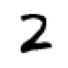

In [48]:
inde=15565
show_image(train_x[inde].view(28,28))
simple_net(train_x[inde]).argmax()